<a href="https://colab.research.google.com/github/Only-Mike/M2-NLP-Network-Analysis/blob/main/NLP_SC_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



In [1]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability (why did the model say it's related to this author)
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import tqdm #progress bar
import preprocessor as prepro # text prepro

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [4]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

fatal: destination path 'M2-NLP-Network-Analysis' already exists and is not an empty directory.


In [5]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [6]:
frames = [data1, data2, data3, data4, data5]

In [7]:
df = pd.concat(frames)

In [8]:
df.shape

(8573, 22)

In [9]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

In [10]:
#Choosing the columns we need to work with and storing them in the value "data"
data = df[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [11]:
#Combining the text and title
data['text'] = data['Title'] + '. ' + data['Abstract']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
#Cleaning the text
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/8573 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|█████████▉| 8552/8573 [01:50<00:00, 129.90it/s]

In [14]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [16]:
data['text_clean'] = text_prepro(data['text'])  ##<---- HVAD GØR DEN HER?<-------##

100%|██████████| 8573/8573 [01:50<00:00, 77.65it/s] 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
# preprocess texts (we need tokens)  <---- Hvad gør den her? <------
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [18]:
data['tokens'] = tokens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
## SPØRGSMÅL OMKRING FILTER 

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

#Model Metrics

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [27]:
corpus = data['tokens']

In [28]:
corpus

0       [food, nutrition, security, southern, african,...
1       [iot, cargo, monitoring, system, operational, ...
2       [annual, software, technology, conference, stc...
3       [approximation, high, dimensional, commodity, ...
4       [accessibility, local, food, production, regio...
                              ...                        
1995    [agile, supply, chain, manufacturing, service,...
1996    [evaluation, cruise, ship, supply, logistics, ...
1997    [systematic, network, analysis, datum, quality...
1998    [stage, optimization, model, tactical, plannin...
1999    [grammar, aware, pointer, network, abstractive...
Name: tokens, Length: 8573, dtype: object

In [ ]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

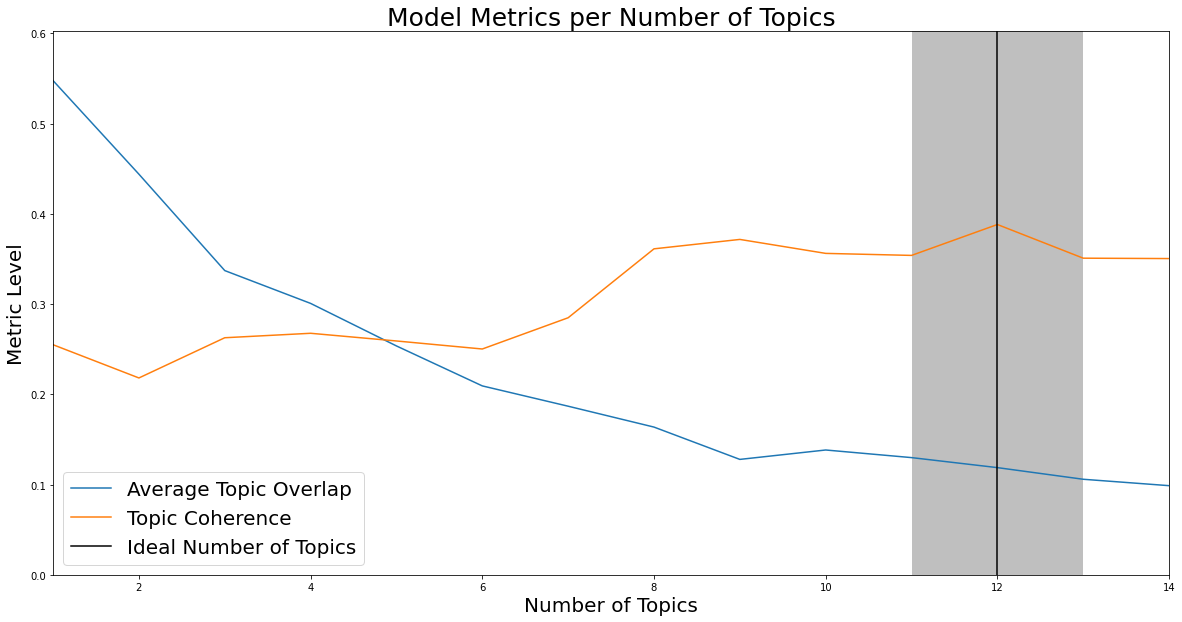

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  

# Visualization

In [23]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, workers = 4, passes=10)

In [24]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [25]:
pyLDAvis.display(lda_display)